<a href="https://colab.research.google.com/github/leedabin2/regression/blob/main/%EA%B0%80%EC%84%A42_%ED%9A%8C%EA%B7%80%EB%B6%84%EC%84%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [문제 2] 의식주 관련비용을 제외한 지출항목 중 하나를 종속변수로 하는 가설을 수립하고 회귀분석을 수행하여 검증하라. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install stargazer
from stargazer.stargazer import Stargazer 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
def residplot(resid):
    plt.figure(figsize=(20,5))
    plt.scatter(range(0,len(resid)),resid, s=0.1)
    plt.axhline()
    plt.show()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# *가설 : 소득이 높을수록 가계지출에서의 교육비가 증가할 것이다.*

1) 회귀식 설명

독립변수 : 소득

종속변수 : 가계지출_소비지출_교육비

통제변수 : 가구원 수, 연령, 학력, 직업

In [ ]:
df= pd.read_csv('drive/MyDrive/data/가계동향조사-2010-2021.csv')

df['교육비비중'] = df['가계지출_소비지출_교육비'] / df['가계지출_소비지출금액']
f1 = df['교육비비중'] > 0 
f = (df['교육비비중'] == 1) | (df['교육비비중'] == 0) # 비율이 0 혹은 1인 경우
smp = df.loc[~f,:] # 해당 경우를 제외하고 smp에 저장

import numpy as np
from scipy.special import logit
y_log = np.log(smp['교육비비중']) # 로그변환

# 분위별 평균 소득 (범주별 연산)
df['소득분위'] = pd.qcut(df['소득'], q = 5, labels = False)
df.groupby('소득분위')[['소득']].apply(lambda x: x / 1000000)

df = df.loc[f1,['조사연도','가구원수','거처구분코드','가구주_연령','가구주_학력코드','소득','소득분위','가구주_7차직업분류코드','가구주_종사상지위코드','교육비비중','자동차보유대수']]
df.columns=['year','n_mb','abode','age','edu','income','income_r','job','worktype','edu_fee','car']

df.income = df.income / 1e6

df.sample(10)

,year,n_mb,abode,age,edu,income,income_r,job,worktype,edu_fee,car
63822,2021,3,아파트,34,고등,3.500000,2,기타무직,NaN,0.194487,1
31765,2020,4,단독-다가구주택,47,대학4,4.100000,3,농림어업,고용원 없는 자영업,0.076509,1
36225,2020,3,아파트,57,중학,5.300665,3,기능원,일용근로,0.415428,0
16956,2019,1,단독-다가구주택,26,석사,3.029900,2,전문가,상용근로,0.042760,0
10419,2019,4,단독-다가구주택,48,대학2,5.700112,3,판매,상용근로,0.178313,0
77505,2010,4,연립주택,33,석사,1.980655,1,2,상용근로,0.145405,1
76600,2010,4,아파트,45,석사,6.466973,4,4,상용근로,0.216917,1
80873,2010,4,아파트,50,고등,2.800401,2,7,고용원 없는 자영업,0.002603,0
78232,2010,4,아파트,41,대학4,3.665555,2,2,상용근로,0.175443,1
18461,2019,5,아파트,39,대학4,10.000000,4,판매,상용근로,0.133720,1


# 회귀 분석 수행

In [ ]:
from statsmodels.formula.api import ols
m1 = ols("edu_fee ~ C(income_r) ",df).fit() 
print(m1.summary())

# r-squared : 교육비비중 종속변수의 변동 7%을 독립변수-소득의 변동으로 설명했다
# F-statistic : 48.16로 매우 낮으며,유의확률이 0.05보다 작아 유의미하다고 볼 수 있다. 따라서 귀무가설(소득이 교육비비중에 영향을 미치지 않는다.)는 기각된다.
# 소득분위가 가장 낮은 가구주들에 비해서 소득이 높은 가구주들의 교육비는 높다는 것을 확인할 수 있다. (ex 가장낮은 분위에 비해 4분위는 0.0327정도 교육비의 비중이 높다.)
# skew : 1.062로 오른쪽으로 치우쳐 있다.

                            OLS Regression Results                            
Dep. Variable:                edu_fee   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     48.16
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           1.97e-40
Time:                        16:11:27   Log-Likelihood:                 19594.
No. Observations:               28250   AIC:                        -3.918e+04
Df Residuals:                   28245   BIC:                        -3.914e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            0.1307      0.003  

로그 변환

In [ ]:
import numpy as np
m1_l = ols('y_log ~ C(income_r)',df).fit()
print(m1_l.summary())

# r-squared 가 아주 조금 높아졌음
# 소득이 가장 낮을 때 교육비의 평균값은 -2,657,800만원임을 알 수 있다.
# 소득분위가 가장 낮은 가구주 대비 소득분위가 높아질수록 교육비의 비중이 높아지고 있음을 알 수 있다. 
# 왜도를 봤을 때, 비대칭성을 보이며 상대적으로 낮은 소득인 가구주들을 과대평가하고 상대적으로 높은 소득을 가진 가구주들을 과소평가하고 있다.

                            OLS Regression Results                            
Dep. Variable:                  y_log   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     59.69
Date:                Fri, 14 Apr 2023   Prob (F-statistic):           2.84e-50
Time:                        16:12:06   Log-Likelihood:                -44724.
No. Observations:               28250   AIC:                         8.946e+04
Df Residuals:                   28245   BIC:                         8.950e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.6578      0.033  

잔차의 관찰 - 로그변환

In [ ]:
resid = pd.DataFrame({'x':df['income_r'], 'resid':m1_l.resid})
resid

,x,resid
1,2,-1.382206
3,2,-1.607086
7,4,-0.303815
10,3,-0.517552
14,3,-2.493042
...,...,...
92596,2,1.651713
92597,3,1.167696
92599,3,-1.438716
92604,4,0.525758


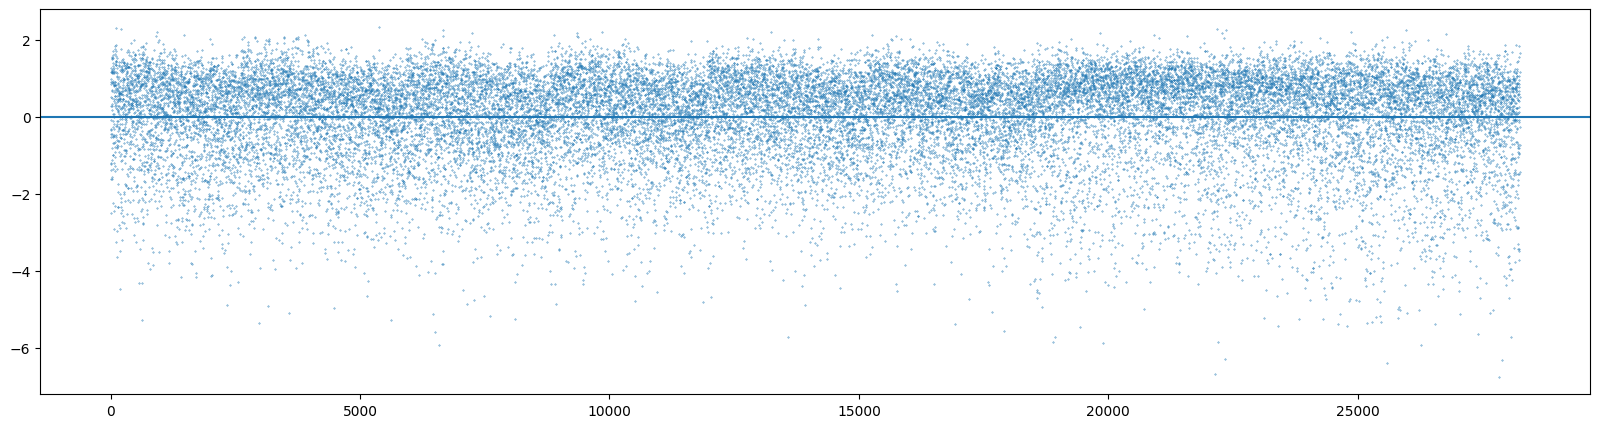

In [ ]:
residplot(resid['resid'])

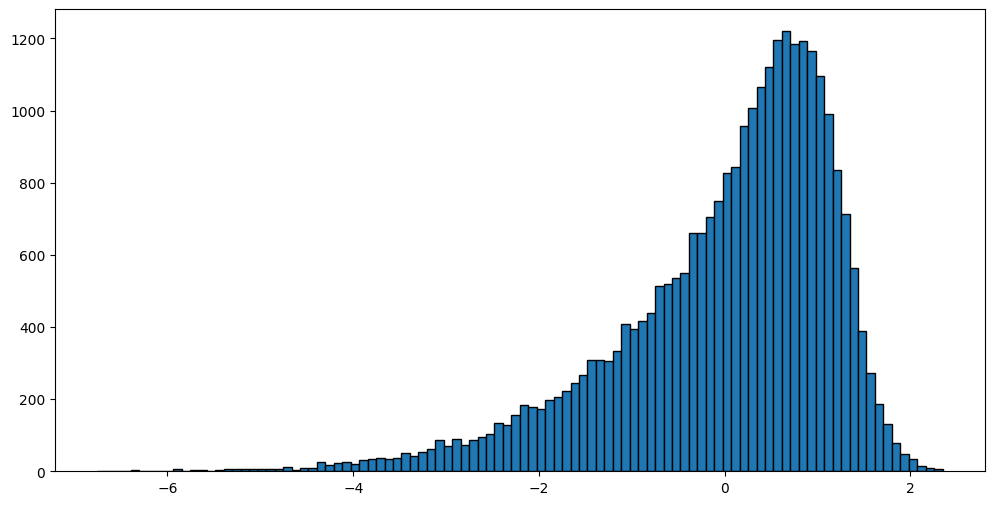

In [ ]:
resid['resid'].hist(figsize=(12,6), bins=100, grid=False, edgecolor='black');
# 정규성이 로그변환했음에도 낮음

다중회귀분석 - 통제변수 검토

In [ ]:
# 가구원 수
df.groupby('n_mb')['edu_fee'].describe()

,count,mean,std,min,25%,50%,75%,max
n_mb,,,,,,,,
1,1661.0,0.120776,0.142829,0.000267,0.026240,0.067675,0.152417,0.882103
2,3957.0,0.125215,0.131373,0.000178,0.025009,0.076855,0.186974,0.822932
3,8035.0,0.136236,0.116413,0.000175,0.042202,0.108485,0.199253,0.718550
4,11294.0,0.170368,0.115723,0.000111,0.077200,0.154902,0.244299,0.816886
5,2806.0,0.173704,0.114267,0.000235,0.085110,0.156614,0.246630,0.704714
6,418.0,0.144206,0.105757,0.000421,0.054131,0.124773,0.214334,0.493391
7,67.0,0.148816,0.100370,0.001205,0.060407,0.130606,0.227561,0.424904
8,9.0,0.148566,0.127659,0.035312,0.096643,0.118185,0.138993,0.476161
9,3.0,0.082161,0.069397,0.036877,0.042213,0.047550,0.104803,0.162056


In [ ]:
# 가구주 연령
bins = [10, 19, 29, 39, 49, 59] 
labels = ['10s', '20s', '30s', '40s', '50s']
df['age_group'] = pd.cut(df['age'], bins=bins, labels=labels)

df.groupby('age_group')['edu_fee'].describe()

,count,mean,std,min,25%,50%,75%,max
age_group,,,,,,,,
10s,12.0,0.251436,0.257862,0.016089,0.047157,0.115532,0.556058,0.628882
20s,839.0,0.114995,0.140876,0.000235,0.025675,0.061454,0.141650,0.882103
30s,6319.0,0.108741,0.092511,0.000111,0.035420,0.086394,0.158993,0.732151
40s,12526.0,0.181177,0.114640,0.000178,0.091183,0.167162,0.255644,0.775766
50s,6320.0,0.163849,0.138735,0.000120,0.048984,0.131385,0.246719,0.839316


In [ ]:
# 직업
df.groupby('job')['edu_fee'].describe()

,count,mean,std,min,25%,50%,75%,max
job,,,,,,,,
1,270.0,0.178652,0.124044,0.000580,0.074719,0.168869,0.256525,0.551435
2,1727.0,0.159772,0.118675,0.000347,0.057725,0.146591,0.242256,0.775766
3,1630.0,0.154253,0.114580,0.000175,0.058486,0.142377,0.231013,0.670889
4,629.0,0.151738,0.123923,0.000120,0.044873,0.127246,0.222636,0.632872
5,893.0,0.168052,0.115861,0.000235,0.072980,0.155619,0.241238,0.626218
6,25.0,0.100804,0.088223,0.006757,0.031971,0.082945,0.137082,0.315499
7,1315.0,0.152278,0.107324,0.000235,0.064364,0.138070,0.220086,0.593883
8,1544.0,0.146058,0.111006,0.000190,0.052160,0.131011,0.215735,0.665719
9,732.0,0.137499,0.113468,0.000111,0.046537,0.112215,0.201064,0.540129


In [ ]:
# 자동차보유대수
df.groupby('car')['edu_fee'].describe()

,count,mean,std,min,25%,50%,75%,max
car,,,,,,,,
0,4458.0,0.150432,0.134774,0.000375,0.040986,0.114790,0.223850,0.882103
1,16808.0,0.151732,0.119953,0.000120,0.053233,0.127817,0.222490,0.816886
2,6696.0,0.152409,0.115249,0.000111,0.058333,0.131688,0.222914,0.719571
3,278.0,0.112767,0.114735,0.000668,0.023869,0.066102,0.167892,0.606060
4,10.0,0.130822,0.136142,0.010742,0.047365,0.089510,0.139696,0.460977


In [ ]:
df['col'] = df['edu'].isin(['대학2', '대학4', '석사', '박사']) # 대졸여부
df.groupby('col')['edu_fee'].describe()

,count,mean,std,min,25%,50%,75%,max
col,,,,,,,,
False,10807.0,0.143216,0.117623,0.000120,0.047687,0.116747,0.211906,0.839316
True,17443.0,0.156303,0.123333,0.000111,0.054495,0.132353,0.230179,0.882103


In [ ]:
import numpy as np
m1 = ols('y_log ~ C(income_r)',df).fit() # 단계적으로 통제변수를 추가하여 차이를 살펴봄
m2 = ols('y_log ~ C(income_r) + C(n_mb)',df).fit() 
m3 = ols('y_log ~ C(income_r) + C(col) + C(n_mb)',df).fit()
m4 = ols('y_log ~ C(income_r) + C(col) + C(age_group) + C(n_mb)',df).fit()
m5 = ols('y_log ~ C(income_r) + C(col) + C(age_group) + C(job) + C(n_mb)',df).fit()

out = Stargazer([m1, m2, m3, m4, m5])
out

# (1) 소득이 가장 낮은 가구주에 비해서 소득이 높아질수록 교육비가 증가하는 것을 볼 수 있다.
# (2) 가구원 수를 통제했을 때, 소득분위만을 변수로 봤을 때보다 확연하게 교육비의 비중이 감소하는 것을 확인할 수 있다.
# (3) 가구원 수와, 학력(대졸)을 통제했을 때, 교육비의 비중이 소득분위만을 놓고 봤을 때보다 감소했다. 특히, 소득분위가 가장 낮은 가구에 비해 1분위가구는 교육비의 비중이 4.2%지만, 2분위 가구는 0.1%밖에 차이나지 않고 있다.
# (3) 대졸인 사람들은 그렇지 않은 사람들에 비해서 7.2% 정도 교육비의 비중이 더 크다.
# (4) 20,30대는 10대에 비해서 교육비의 비중이 81% 낮다. 
# (5) 직업변수를 통제한 경우, 교육비의 비중이 낮아지는 것을 볼 수 있다.
 

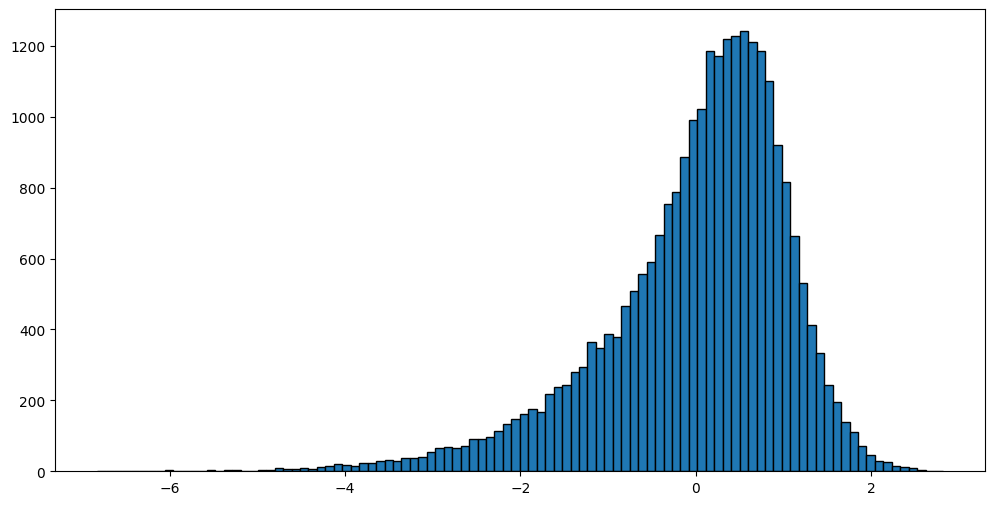

In [ ]:
m5.resid.hist(bins=100, figsize=(12,6), grid=False, edgecolor='black'); # 잔차도

극단치 제거 

In [ ]:
f1 = df['edu_fee'] > df['edu_fee'].quantile(0.01)
f2 = df['edu_fee'] < df['edu_fee'].quantile(0.99)
smp2 = df.loc[f1 & f2,:]

In [ ]:
m1 = ols('np.log(edu_fee)  ~ C(n_mb) + C(job) + C(col) + C(age_group) ',smp2).fit()
m2 = ols('np.log(edu_fee)  ~ C(income_r) + C(job) + C(col) + C(age_group)',smp2).fit()
m3 = ols('np.log(edu_fee)  ~ C(n_mb) + C(income_r) + C(job) + C(col) + C(age_group)',smp2).fit()
m4 = ols('np.log(edu_fee)  ~ C(n_mb)*C(income_r) + C(job) + C(col) + C(age_group)',smp2).fit() # 가구수와 가구 소득 구간의 상호작용항을 설명변수로 사용한 모델
out = Stargazer([m1, m2, m3, m4])
out

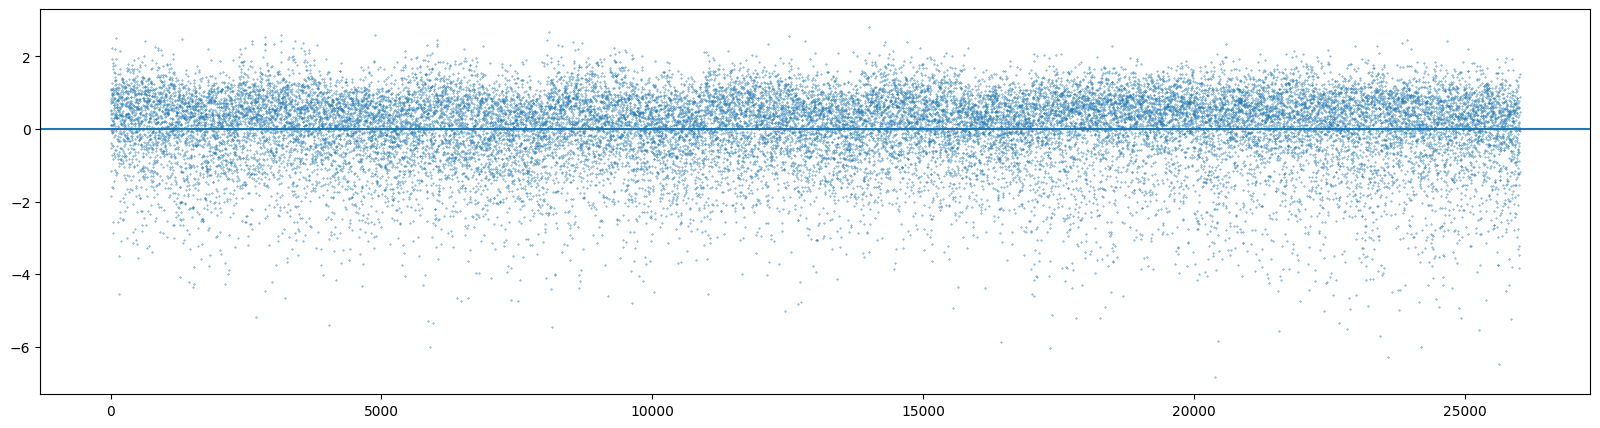

In [ ]:
residplot(m5.resid)

<Axes: >

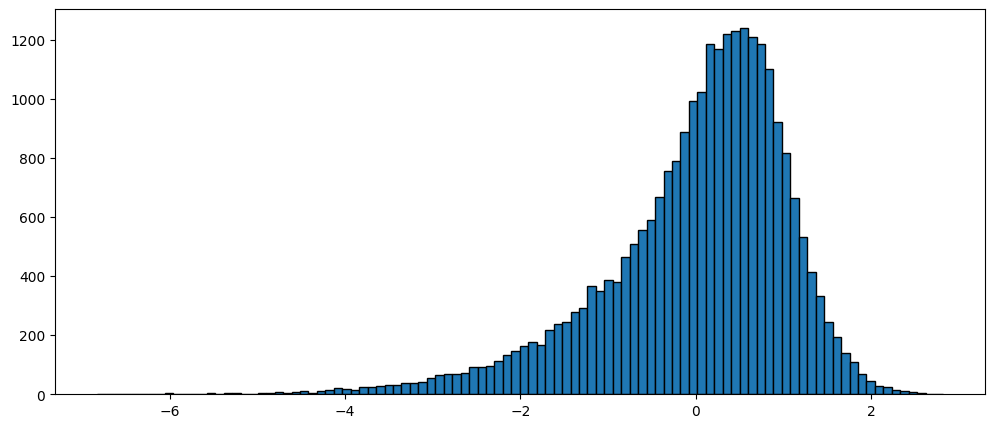

In [ ]:
m5.resid.hist(bins=100, figsize=(12,5), edgecolor='black', grid=False)

결론적으로 통제되지 않은 변수(가구원 수,학력,연령,직업)에 따라서 교육비가 차지하는 비중이 감소되는 것을 확인할 수 있다. 그러나 극단치를 제거했음에도 여전히 정규성을 띄지 않고있어 데이터를 적절이 변환하는 등의 검토가 필요하다.